### Nama : Muhamad Kurniawan Fauzi
### NIM : 5312422037
### Prodi : Teknik Komputer
---

# Tapis/Filter dan Jendela

ㅤㅤKita ingin merancang filter FIR kausal dengan respons frekuensi mirip dengan filter ideal low pass yang memiliki respons impuls sinc. Filter ideal ini tidak dapat diimplementasikan secara praktis karena bersifat non-kausal dan dimulai dari minus tak hingga.
Dalam pengolahan sinyal, terutama dalam konversi tingkat sampel audio, seringkali kita ingin mendekati filter ideal seperti filter low pass dengan respons impuls sinc. Meskipun filter ideal ini tidak dapat diimplementasikan secara langsung, kita ingin mendekatinya dengan filter FIR yang dapat dijalankan dalam sistem digital.
 <br><br>
ㅤㅤLangkah pertama adalah mendefinisikan respons frekuensi yang diinginkan $H_d(ω)$, yang merupakan respons frekuensi dari filter ideal low pass. Filter FIR yang dihasilkan, $H(ω)$, harus mendekati $H_d(ω)$. Semakin mendekati, semakin kecil juga errornya. Errornya dapat dihitung dengan persamaan berikut ini:

$e = \int_{0}^{2\pi} \left| H_d(\omega) - H(\omega) \right|^2 d\omega$

ㅤㅤSetelah itu, bisa digunakan persamaan sinc untuk memperoleh respon impuls dari $h(n)$, yaitu dengan persamaan berikut ini

$h(n) = \frac{\sin((n - n_d) \omega_p)}{(n - n_d) \omega_p}$
<br><br>
ㅤㅤDengan ini kita bisa melakukan downsampling sinyal suara CD yang sebelumnya 44.1kHz ke 22kHz. Berikut adalah kode

<ipython-input-1-f14c4b7499a2>:18: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.arange(-4, L+4, step=1), h, use_line_collection=True)


interactive(children=(IntSlider(value=16, description='L', max=128, min=2), Checkbox(value=False, description=…

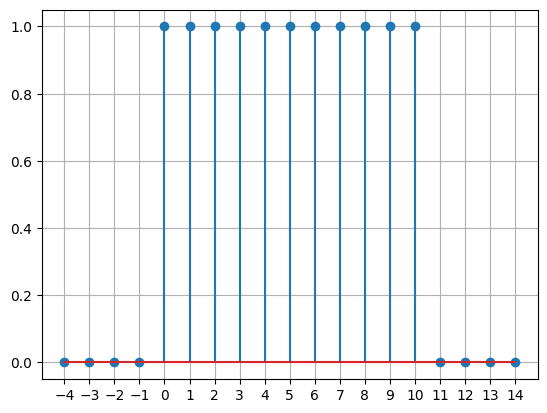

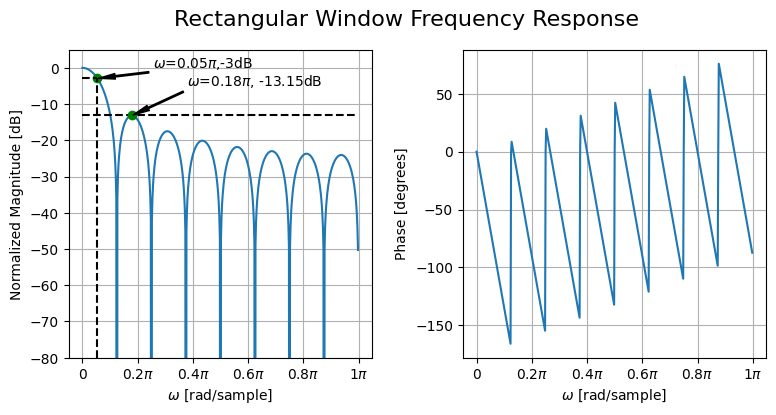

In [1]:
# import library yang dibutuhkan
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from matplotlib.ticker import FuncFormatter, MultipleLocator
from scipy.signal import argrelextrema
import scipy.signal as signal

# inisialisasi panjang filter L
L=11

# membuat filter FIR dengan window rectangular
h = np.concatenate((np.zeros(4), np.ones(L), np.zeros(4)), axis=0)

# plot impulse response dari filter FIR dengan menggunakan stem plot
plt.figure()
plt.stem(np.arange(-4, L+4, step=1), h, use_line_collection=True)
plt.xticks(np.arange(-4, L+4, step=1))
plt.grid()

# membuat subplot untuk menampilkan respons frekuensi dari filter FIR
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
fig.suptitle('Rectangular Window Frequency Response', fontsize=16)
plt.subplots_adjust(wspace=0.3)

# fungsi interaktif untuk memplot respons frekuensi filter FIR
@interact(L=widgets.IntSlider(min=2, max=128, step=1, value=16), unwrap=False)
def plot_recWindow_H(L=16, unwrap=False):
    # membuat filter FIR dengan window rectangular berdasarkan panjang L yang dipilih
    h = np.concatenate((np.ones(L), np.zeros(4)), axis=0)

    # menghitung respons frekuensi dari filter FIR dengan menggunakan freqz dari library scipy.signal
    omega, H = signal.freqz(h[:-4], worN=512)

    # mengonversi respons frekuensi ke dalam dB
    H[np.abs(H) < np.finfo(float).eps] = np.finfo(float).eps
    H_dB = 20 * np.log10(np.abs(H) / np.abs(H).max())

    # mencari cut-off frequency pada -3 dB
    p3dB = np.max(H_dB) - 3
    p3dBIndex = np.max(np.where(H_dB >= p3dB))
    wp = omega[p3dBIndex]
    Hp = H_dB[p3dBIndex]

    # memplot respons frekuensi dalam domain frekuensi
    ax1.clear()
    ax1.plot(omega, H_dB)
    ax1.plot(wp, Hp, 'go')
    ax1.plot((0, wp), (Hp, Hp), 'k--')
    ax1.plot((wp, wp), (-80, Hp), 'k--')
    ax1.set_ylim((-80, H_dB.max() + 5))
    ax1.annotate(r'$\omega$={:.2f}$\pi$,-3dB'.format(wp/np.pi), xy=(wp, Hp), xytext=(wp + 0.2 * np.pi, 0),
                 arrowprops=dict(facecolor='black', shrink=0.02, width=1, headwidth=4))

    # menambahkan informasi pada plot jika L tidak sama dengan 2
    if L != 2:
        side_lobe = argrelextrema(np.abs(H), np.greater)[0][0]
        ax1.plot((0, omega[-1]), (H_dB[side_lobe], H_dB[side_lobe]), 'k--')
        ax1.annotate(r'$\omega$={:.2f}$\pi$, {:.2f}dB'.format(omega[side_lobe]/np.pi, H_dB[side_lobe]),
                     xy=(omega[side_lobe], H_dB[side_lobe]), xytext=(omega[side_lobe] + 0.2 * np.pi, -5),
                     arrowprops=dict(facecolor='black', shrink=0.02, width=1, headwidth=4))
        ax1.plot(omega[side_lobe], H_dB[side_lobe], 'go')

    # konfigurasi label pada sumbu x dan y
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'))
    ax1.xaxis.set_major_locator(MultipleLocator(base=0.2 * np.pi))
    ax1.grid(True)
    ax1.set_xlabel(r'$\omega$ [rad/sample]')
    ax1.set_ylabel(r'Normalized Magnitude [dB]')

    # memplot respons frekuensi dalam domain fase
    ax2.clear()
    phase = np.angle(H, deg=True)
    if unwrap:
        phase = np.unwrap(phase)
    ax2.plot(omega, phase)
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'))
    ax2.xaxis.set_major_locator(MultipleLocator(base=0.2 * np.pi))
    ax2.grid(True)
    ax2.set_xlabel(r'$\omega$ [rad/sample]')
    ax2.set_ylabel(r'Phase [degrees]')


Dalam penjelasan sebelumnya, telah teelihat bahwa respons frekuensi dari filter FIR dengan window rectangular tidak menyerupai impuls pada frekuensi nol. Sebenarnya, respons tersebut agak lebar dan juga attenuasinya tidak terlalu tinggi, berkisar antara -15 hingga -20 dB. Kita mengharapkan bahwa filter low pass yang dihasilkan akan "mewarisi" sifat-sifat ini melalui konvolusi dalam domain frekuensi.

Lebar "pass band" atau lengan utama dari fungsi jendela kita akan menentukan lebar band transisi dari filter yang dihasilkan kita, dan attenuasi "stop band" dari jendela akan menentukan attenuasi stop band yang dihasilkan dari filter kita. Dengan ini menunjukkan bahwa fungsi jendela membentuk karakteristik utama dari filter FIR yang dihasilkan.

Contoh: Ambil contoh filter downsampling yang seharusnya melemahkan frekuensi mulai dari 11 kHz, pada kecepatan pengambilan sampel 44.1 kHz. Tujuannya adalah untuk attenuasi -60 dB di stopband. Oleh karena itu, dapat diperoleh frekuensi terstandarisasi untuk awal stop band kita sebagai berikut:

$ \omega_s = \frac{11}{44.1} \cdot 2 \pi \approx 0.5 \pi $

Oleh karena itu, respons frekuensi yang diinginkan adalah 1 antara frekuensi 0 dan $\omega_s$ (atau lebih baik: antara $-\omega _s$ hingga $\omega _s$ untuk juga mencakup sumbu frekuensi negatif). Sekarang ambil invers DTFT dari respons frekuensi ideal yang diinginkan $H_d(\omega)$ untuk memperoleh impulse response ideal $h_d(n)$. Karena pada awalnya kita mengasumsikan filter ideal, kita menetapkan akhir dari pass band $\omega_c$ identik dengan awal dari stop band, $\omega_c=\omega_s$:

$
h_d(n) = \frac{1}{2 \pi} \cdot \int_{\omega=-\pi}^{\pi} H_d(\omega) e^{j \omega n} d\omega = \frac{1}{2 \pi} \cdot \int_{\omega=-\omega_c}^{\omega_c} e^{j \omega n} d\omega = \frac{1}{2 \pi} \left( \frac{e^{j \omega_c n}}{j \cdot n} - \frac{e^{-j \omega_c n}}{j \cdot n} \right) = \frac{\sin(\omega_c n)}{\pi n}
$

# Pendekatan Implementasi Low Pass Filter Ideal dengan Menggunakan Tapis Rektangular dan Delay

Dari sini bisa diyakini jika impulse respon dari low pass filter yang ideal memiliki persamaan seperti berikut ini:

$$\large
h(n)=\frac{sin(\omega_c \cdot n)}{\pi \cdot n }$$

Dengan memangkas impulse respon yang diperoleh dengan mengalikannya dengan window rektangular sebelumnya dapat memberikan:

$$\large
h(n)=\frac{sin\left(\omega_c \cdot (n-n_d)\right)}{\pi \cdot (n-d_d)} =
\frac{sin\left(\omega_c \cdot \left(n-\frac{(L-1)}{2}\right)\right)}{\pi \cdot \left(n-\frac{(L-1)}{2}\right)}
$$



In [6]:
#import library
from sympy import sin, symbols, simplify, pi, lambdify, limit
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from matplotlib.ticker import FuncFormatter, MultipleLocator
from scipy.signal import freqz, argrelextrema

# Definisikan simbol dan rumus untuk impulse response
wc_s = symbols('\omega_c')  # Simbol omega_c untuk frekuensi cut-off
n_s, L_s = symbols('n L', integer=True)  # Simbol n dan L untuk panjang filter

n_d_s=(L_s-1)/2
h_n_s=sin(wc_s*(n_s-n_d_s))/(pi*(n_s-n_d_s))
h_n_s

sin(\omega_c*(-L/2 + n + 1/2))/(pi*(-L/2 + n + 1/2))

In [7]:
# Limit dari h_n_s ketika n_s mendekati n_d_s
h_0_s = limit(h_n_s,n_s,n_d_s)
h_0_s

\omega_c/pi

interactive(children=(IntSlider(value=16, description='L', max=128, min=2), FloatSlider(value=0.5, description…

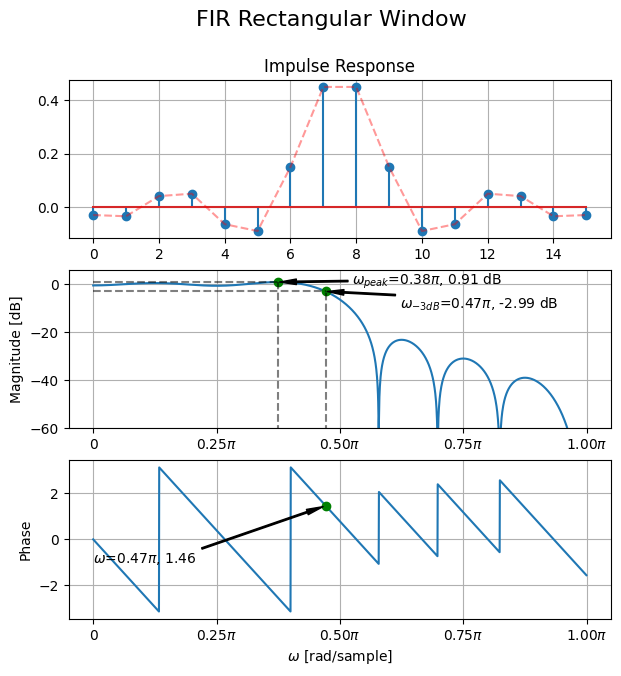

In [8]:
# Fungsi lambdify untuk mengubah simbol menjadi fungsi numpy
h_n = lambdify((wc_s, n_s, L_s), h_n_s, 'numpy')

# Inisiasi figure dan axes untuk plot
fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 7))
fig1.suptitle('FIR Rectangular Window', fontsize=16)
plt.subplots_adjust(wspace=0.3)

# Fungsi interaktif untuk plotting impulse response dan magnitude response
@interact(L=widgets.IntSlider(min=2, max=128, step=1, value=16),
          wc=widgets.FloatSlider(min=0.1, max=1, step=0.01, value=0.5), unwrap=False)
def plot_h(L=16, wc=0.5, unwrap=False):
    wc = wc * np.pi  # Konversi wc ke radian
    n = np.arange(L)
    n_d = n_d_s.subs(L_s, L).evalf()  # Hitung nilai n_d berdasarkan L

    # Generate impulse response menggunakan rumus h_n_s
    if L % 2 == 0:
        h = h_n(wc, n, L)
    else:
        h = np.ones(L)
        for i in range(L):
            if i == n_d:
                h[i] = wc / np.pi
            else:
                h[i] = h_n(wc, i, L)

    # Plot impulse response
    ax1.clear()
    ax1.stem(h, use_line_collection=True)
    ax1.plot(h, 'r--', alpha=0.4)
    ax1.set_title('Impulse Response')
    ax1.grid()

    # Hitung frequency response menggunakan scipy.signal.freqz
    omega, H = freqz(h, worN=2048)
    H[np.abs(H) < np.finfo(float).eps] = np.finfo(float).eps  # Avoid log(0) issue
    H_dB = 20 * np.log10(np.abs(H))

    # Tentukan -3dB point
    p3dB = -3
    p3dBIndex_down = np.max(np.where(H_dB >= p3dB))
    p3dBIndex_up = np.min(np.where(H_dB <= p3dB))
    if (np.abs(p3dB - H_dB[p3dBIndex_down]) >= np.abs(p3dB - H_dB[p3dBIndex_up])):
        p3dBIndex = p3dBIndex_up
    else:
        p3dBIndex = p3dBIndex_down
    wp = omega[p3dBIndex]
    Hp = H_dB[p3dBIndex]
    max_peak_ind = np.argmax(H_dB)

    # Plot magnitude response
    ax2.clear()
    ax2.plot(omega, H_dB)
    ax2.plot(omega[max_peak_ind], H_dB[max_peak_ind], 'go')
    ax2.plot((0, omega[max_peak_ind]), (H_dB[max_peak_ind], H_dB[max_peak_ind]), 'k--', alpha=0.5)
    ax2.plot((omega[max_peak_ind], omega[max_peak_ind]), (-80, H_dB[max_peak_ind]), 'k--', alpha=0.5)
    ax2.annotate(f'$\omega_{{peak}}$={omega[max_peak_ind]/np.pi:.2f}$\pi$, {H_dB[max_peak_ind]:.2f} dB',
                 xy=(omega[max_peak_ind], H_dB[max_peak_ind]), xytext=(omega[max_peak_ind]+0.15*np.pi, 0),
                 arrowprops=dict(facecolor='black', shrink=0.02, width=1, headwidth=4))
    ax2.plot(wp, Hp, 'go')
    ax2.plot((0, wp), (Hp, Hp), 'k--', alpha=0.5)
    ax2.plot((wp, wp), (-80, Hp), 'k--', alpha=0.5)
    ax2.set_ylabel('Magnitude [dB]')
    ax2.grid()
    ax2.set_ylim((-60, H.max()+5))
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f'{val/np.pi:.2f}$\pi$' if val != 0 else '0'))
    ax2.xaxis.set_major_locator(MultipleLocator(base=0.25*np.pi))
    ax2.annotate(f'$\omega_{{-3dB}}$={wp/np.pi:.2f}$\pi$, {Hp:.2f} dB', xy=(wp, Hp),
                 xytext=(wp+0.15*np.pi, -10), arrowprops=dict(facecolor='black', shrink=0.02, width=1, headwidth=4))

    # Plot phase response
    ax3.clear()
    phase = np.angle(H, deg=False)
    if unwrap:
        phase = np.unwrap(phase)
        print(f'Delay={phase[p3dBIndex]/wp:.2f}')
    ax3.plot(omega, phase)
    ax3.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f'{val/np.pi:.2f}$\pi$' if val != 0 else '0'))
    ax3.xaxis.set_major_locator(MultipleLocator(base=0.25*np.pi))
    ax3.grid(True)
    ax3.set_xlabel(r'$\omega$ [rad/sample]')
    ax3.set_ylabel('Phase')
    ax3.plot(wp, phase[p3dBIndex], 'go')
    ax3.annotate(f'$\omega$={wp/np.pi:.2f}$\pi$, {phase[p3dBIndex]:.2f}',
                 xy=(wp, phase[p3dBIndex]), xytext=(0, -1),
                 arrowprops=dict(facecolor='black', shrink=0.02, width=1, headwidth=4))


Mari kita ulas beberapa hal terkait program sebelumnya dan hubungannya dengan konsep Gibbs Phenomenon.

Ketika kita menggunakan filter FIR kausal dengan fungsi jendela berbentuk persegi (rectangular window), kita mengamati beberapa karakteristik yang muncul dalam respons frekuensinya:

- Ripple pada Pass Band: Filter kita menunjukkan riak-riak sekitar +/- 0.5 dB di dalam pass band. Ini dapat diterima karena riak sekecil ini hanya mencerminkan sekitar 6% overshoot atau undershoot, yang umumnya masih dapat diterima.
- Attenuation Kurang pada Stop Band: Filter ini tidak memenuhi persyaratan attenuasi minimal -60 dB pada frekuensi terormalisasi 0.5 * π. Dapat dilihat bahwa pada frekuensi ini, filter hanya memberikan sekitar -10 dB attenuasi, dan lobus samping pertama hanya sekitar -20 dB attenuasi.
- Fenomena Gibbs: Ketika kita memperbesar panjang filter (L), kita mungkin mengharapkan bahwa kesalahan atau riak-riak di sekitar pass band dan stop band akan berkurang. Namun, yang terjadi sebenarnya adalah fenomena Gibbs. Ini mengacu pada fakta bahwa meskipun riak-riak ini menjadi lebih sempit dengan peningkatan panjang filter, tinggi riaknya tetap relatif konstan, sekitar 0.1 dalam stop band (ekivalen dengan sekitar -20 dB).
Hal ini menunjukkan bahwa:

Kesalahan maksimum yang dihasilkan tidak berkurang seiring dengan peningkatan panjang filter.Meskipun area riak-riak di sekitar pass band dan stop band mengecil, tinggi riaknya tetap sama.
Untuk mengatasi masalah ini, kita dapat mempertimbangkan penggunaan jendela alternatif selain jendela persegi. Beberapa jendela yang umum digunakan, seperti raised cosine atau sine windows, dapat memberikan riak-riak yang lebih rendah dalam domain frekuensi.